In [1]:
!pip install git+https://github.com/huggingface/transformers
!pip install flash_attn

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-csll96ad
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-csll96ad

  Resolved https://github.com/huggingface/transformers to commit a564d10afe1a78c31934f0492422700f61a0ffc0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


### Let's Clone the Model

For this notebook we will try the brand new "Phi-3-vision-128k-instruct" released by Microsoft.
You can download it using git lfs or directly using AutoModelForCausalLM.from_pretrained in the cell above.

In [2]:
!git lfs install
!git clone https://huggingface.co/microsoft/Phi-3-vision-128k-instruct

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
fatal: destination path 'Phi-3-vision-128k-instruct' already exists and is not an empty directory.


⚡️ Tip	Check organization access: https://github.com/settings/connections/applications/c7457225b242a94d60c6



In [3]:
from PIL import Image
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
import os

### Insert above the path to the model

In [4]:
model_id = os.getcwd() +"/Phi-3-vision-128k-instruct"

### Load checkpoint of the model and processor

In [5]:
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda:0",trust_remote_code=True,torch_dtype="auto")
processor = AutoProcessor.from_pretrained(model_id,trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Let's define some utility functions

In [6]:
def define_messages(prompr):
    messages = [ 
        {"role": "user", "content": f"<|image_1|>\n{prompt}"}
    ] 
    return messages

import requests
def download_image(url):
    image = Image.open(requests.get(url,stream=True).raw)
    return image

In [7]:
url = "https://www.shutterstock.com/image-photo/profile-side-view-portrait-attractive-260nw-2069676638.jpg"
image = download_image(url)

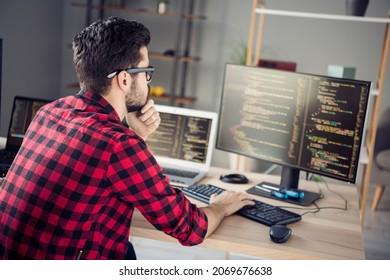

In [8]:
image.show()

### Let's prepare the inputs

In [10]:
prompt = "What do you see in the image?"

In [11]:
input_prompt = processor.tokenizer.apply_chat_template(define_messages(prompt),tokenize=False,add_generation_prompt=True)

In [12]:
inputs = processor(input_prompt, [image], return_tensors="pt").to("cuda:0") 

### Generation

In [13]:
generation_args = { 
    "max_new_tokens": 500, 
    "temperature": 0.0, 
    "do_sample": False, 
} 

generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args) 

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:533: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [14]:
generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0] 
response

'The image shows a person sitting at a desk in front of two computer monitors. The person is wearing a red and black checkered shirt and has their hand on their chin, suggesting a thoughtful or contemplative pose. The monitors display various lines of code or text, indicating that the person might be working on a programming or coding project. The room has a modern feel with a wooden desk and a whiteboard in the background.'

In [16]:
del model

### Let's wrap up everything in one simple class

In [21]:
class VisionLLM():
    def __init__(self,model_id,max_new_tokens=500,temperature=0.0,do_sample=False):
        self.model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda:0",trust_remote_code=True,torch_dtype="auto")
        self.processor = AutoProcessor.from_pretrained(model_id,trust_remote_code=True)
        self.generation_args = { 
            "max_new_tokens": max_new_tokens, 
            "temperature": temperature, 
            "do_sample": do_sample, 
        } 

    def __define_messages(self,prompt):
        messages = [ 
            {"role": "user", "content": f"<|image_1|>\n{prompt}"}
        ] 
        return messages


    def generate(self,image,prompt):
        input_prompt = processor.tokenizer.apply_chat_template(self.__define_messages(prompt),tokenize=False,add_generation_prompt=True)
        inputs = processor(input_prompt, [image], return_tensors="pt").to("cuda:0") 
        generate_ids = self.model.generate(**inputs, eos_token_id=self.processor.tokenizer.eos_token_id, **generation_args) 
        generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
        response = self.processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0] 
        return response

In [22]:
visionLLM = VisionLLM(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


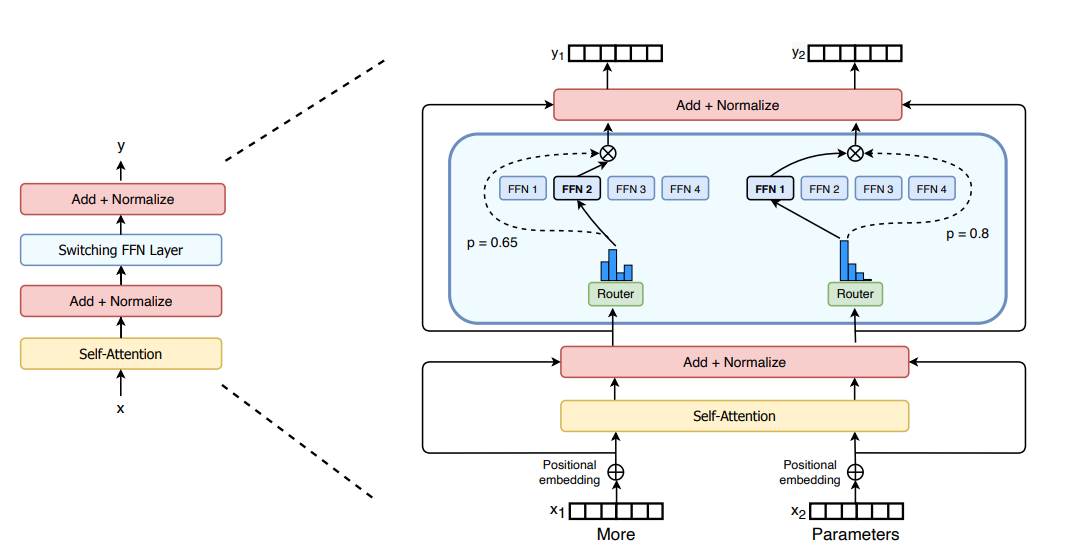

In [23]:
image = download_image(url="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/moe/03_switch_layer.png")
image.show()

In [24]:
output = visionLLM.generate(image=image,prompt="Describe in detail the image provided")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:533: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [25]:
print(output)

The diagram illustrates a neural network architecture with various components and their connections. At the bottom, there are two inputs labeled 'x1' and 'x2', each undergoing a 'Positional embedding' process. These embeddings are then fed into a 'Self-Attention' block. The output of the self-attention block is then passed through an 'Add + Normalize' block. This output is then split into two paths: one leading to a 'Switching FFN Layer' and the other to a 'Router'. The switching FFN layer has four FFN blocks labeled 'FFN 1', 'FFN 2', 'FFN 3', and 'FFN 4', each with a 'p' value of 0.65. The router has two outputs labeled 'y1' and 'y2'. The diagram also shows a feedback loop from the router back to the 'Add + Normalize' block at the top, indicating a recurrent process. The entire structure is enclosed within a larger box, suggesting that these components are part of a larger system or model.


The diagram illustrates a neural network architecture with various components and their connections. At the bottom, there are two inputs labeled 'x1' and 'x2', each undergoing a 'Positional embedding' process. These embeddings are then fed into a 'Self-Attention' block. The output of the self-attention block is then passed through an 'Add + Normalize' block. This output is then split into two paths: one leading to a 'Switching FFN Layer' and the other to a 'Router'. The switching FFN layer has four FFN blocks labeled 'FFN 1', 'FFN 2', 'FFN 3', and 'FFN 4', each with a 'p' value of 0.65. The router has two outputs labeled 'y1' and 'y2'. The diagram also shows a feedback loop from the router back to the 'Add + Normalize' block at the top, indicating a recurrent process. The entire structure is enclosed within a larger box, suggesting that these components are part of a larger system or model.

### Not perfect but not bad at all